<a href="https://colab.research.google.com/github/calamistratus/Overdue-payments-analysis/blob/main/TZ_devim_RU_COLAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

from matplotlib import colormaps
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [ ]:
path =  input('Input the path to the data folder ')

orders = pd.read_csv(os.path.join(path, 'orders.csv'))
payments = pd.read_csv(os.path.join(path, 'payments.csv'))
plan = pd.read_csv(os.path.join(path, 'plan.csv'))

Input the path to the data folder /content/drive/MyDrive/TZ-devim


In [ ]:
plt.style.use('dark_background')

plt.rcParams['font.family'] = 'monospace'

# Первый взгляд

После импорта библиотек можно осмотреть представленные датасеты, проверить их на отсутвующие данные.
В plan.csv отображены суммы к оплате, в payments.csv же - индивидуальные переводы. Это надо будет рассмотреть и переработать, чтобы анализировать просроченные платежи.

9276 отсутсвующих данных есть в plan.csv, но можно предположить, что это задуманно, так как они выходят за рамки.

In [ ]:
orders

,order_id,created_at,put_at,closed_at,issued_sum
0,400001732,2022-06-02 00:00:23.997,2022-06-02 20:18:00.180,2022-10-17 11:52:22.190,13600.0
1,400005838,2022-06-02 00:10:22.997,2022-06-02 15:41:33.267,2022-06-02 17:38:43.917,20000.0
2,400007915,2022-06-02 00:18:04.000,2022-06-05 19:17:38.547,2022-06-21 21:55:51.877,5820.0
3,400008952,2022-06-02 00:22:07.000,2022-06-03 14:25:18.033,2022-07-12 10:47:46.307,9000.0
4,400009027,2022-06-02 00:25:39.000,2022-06-02 00:40:40.320,2022-06-22 14:15:07.423,5000.0
...,...,...,...,...,...
55743,495174013,2022-08-31 23:29:32.000,2022-09-01 00:07:26.307,NaN,9500.0
55744,495174505,2022-08-31 23:41:57.997,2022-09-05 17:51:19.003,2022-09-16 18:36:09.857,14930.0
55745,495175322,2022-08-31 23:46:04.997,2022-09-01 00:03:52.010,2022-09-09 21:08:18.970,4000.0
55746,495176080,2022-08-31 23:47:20.997,2022-08-31 23:49:03.027,2022-09-12 00:58:57.037,5000.0


In [ ]:
print(orders.isnull().sum())

order_id         0
created_at       0
put_at           0
closed_at     9276
issued_sum       0
dtype: int64


In [ ]:
payments

,order_id,paid_at,paid_sum
0,400013633,2022-06-02 00:48:13.800,2500.00
1,400018480,2022-06-02 01:52:05.707,1070.00
2,400032001,2022-06-02 04:55:40.307,4200.00
3,400033195,2022-06-02 05:44:23.480,2850.00
4,400039407,2022-06-02 06:53:54.503,10100.00
...,...,...,...
143279,469255350,2022-12-08 12:57:23.747,343.99
143280,452985418,2022-12-08 12:59:40.997,984.83
143281,490824962,2022-12-08 13:09:21.673,866.04
143282,480026135,2022-12-08 13:25:11.987,1193.25


In [ ]:
payments.isnull().sum()

,0
order_id,0
paid_at,0
paid_sum,0


In [ ]:
plan

,order_id,plan_at,plan_sum_total
0,400001732,2022-06-02,5600.00
1,400001732,2022-07-02,9450.00
2,400001732,2022-08-01,12170.00
3,400001732,2022-08-31,14890.00
4,400001732,2022-09-30,17610.00
...,...,...,...
420277,495177509,2022-12-22,34248.70
420278,495177509,2023-01-06,36863.04
420279,495177509,2023-01-21,39440.38
420280,495177509,2023-02-05,41980.73


In [ ]:
plan.isnull().sum()

,0
order_id,0
plan_at,0
plan_sum_total,0


In [ ]:
plan['plan_at'] = pd.to_datetime(plan['plan_at'])  # Converting to datetime
payments['paid_at'] = pd.to_datetime(payments['paid_at'])
for i in ['put_at', 'created_at', 'closed_at']:
  orders[i] = pd.to_datetime(orders[i])

plan = plan[plan['plan_at'] <= payments['paid_at'].max()].copy()  #Only the valid data

sub_orders = orders[['created_at', 'closed_at', 'order_id']].copy()
sub_orders.loc[:, 'mean_time_order'] = sub_orders[['created_at', 'closed_at']].mean(axis=1)
sub_orders = sub_orders.set_index('order_id')
sub_orders_dict = sub_orders['mean_time_order'].to_dict()

# Базовая Статистика

После проверки данных, я анализирую то, что лежит на поверхности, без манипуляций над данными.

Эти таблицы были бы полезны, например, технической команде.

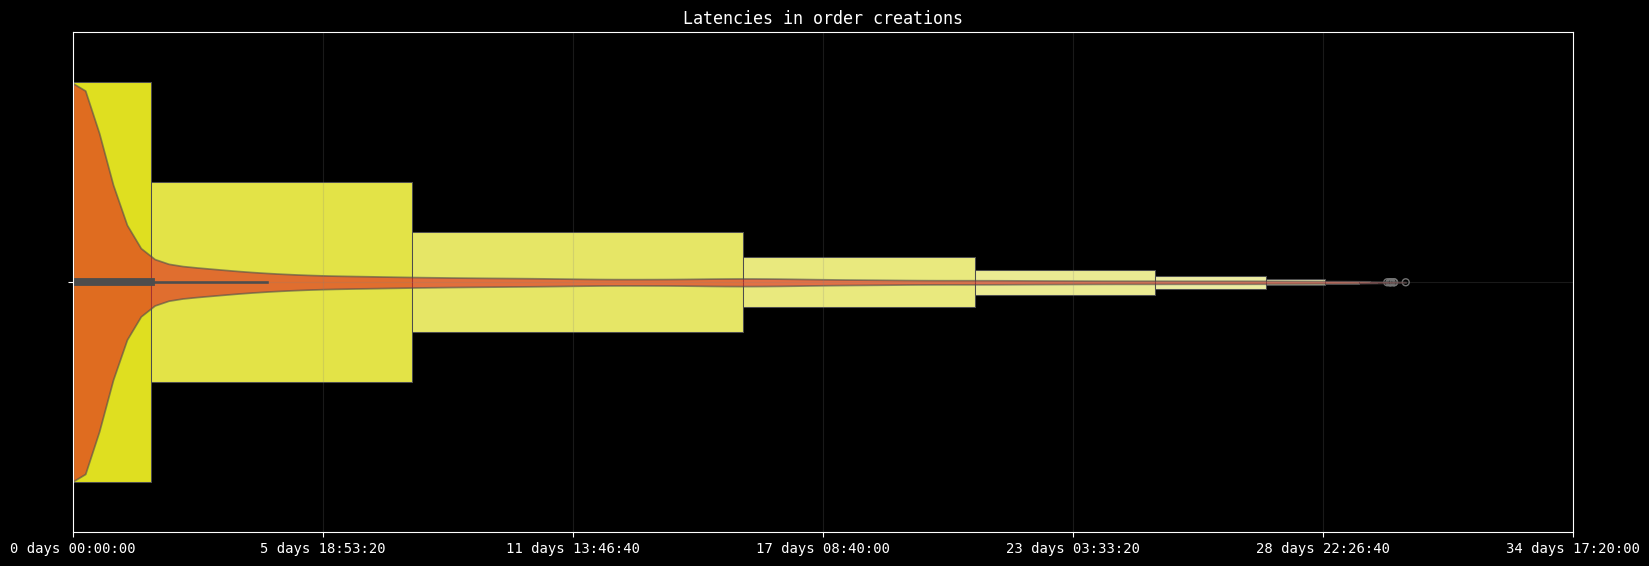

In [ ]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_axes([0, 0, 1, 1])

timedeltas = (orders['put_at']-orders['created_at']).astype(int)
sns.boxenplot(timedeltas, orient='h', ax=ax, color='yellow')
sns.violinplot(timedeltas, orient='h', ax=ax, cut=0, alpha=.6, color='red')

xticklabels = []
xticks = []
for i in ax.get_xticks():
  if i >= 0:
    xticks.append(i)
    xticklabels.append(str(pd.to_datetime(i) - pd.to_datetime(0)))

ax.set_xlim(min(xticks), max(xticks))
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.grid(True, alpha=.2, color='grey')

plt.title('Latencies in order creations')
plt.show()

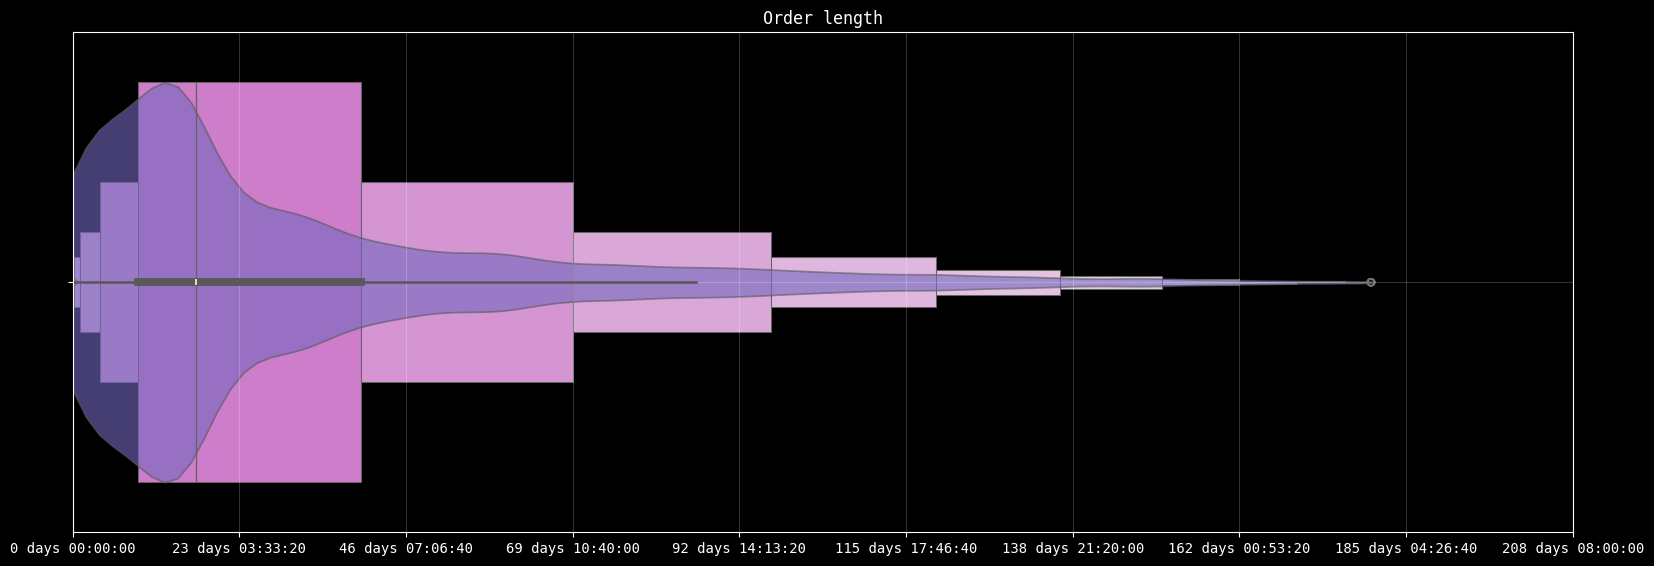

In [ ]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_axes([0, 0, 1, 1])

timedeltas = (orders['closed_at']-orders['put_at']).astype(int)
timedeltas = timedeltas[timedeltas>0]
sns.boxenplot(timedeltas, orient='h', ax=ax, color='orchid')
sns.violinplot(timedeltas, orient='h', ax=ax, cut=0, alpha=.6, color='slateblue')

xticklabels = []
xticks = []
for i in ax.get_xticks():
  if i >= 0:
    xticks.append(i)
    xticklabels.append(str(pd.to_datetime(i) - pd.to_datetime(0)))

ax.set_xlim(min(xticks), max(xticks))
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.grid(True, alpha=.2, color='white')

plt.title('Order length')
plt.show()

# Заметка о структуре даты

Как показано в предоставленных мною таблицах, данная мне дата включает показывает только заказы, сделанные за первые три месяца, что серьёзно повлияет на статистику и усложнит задачу.

Также можно увидеть спад/рост активности после 2022-10, 2022-11-5, 2022-11-25
Эпицентром активности был 2022-08-10

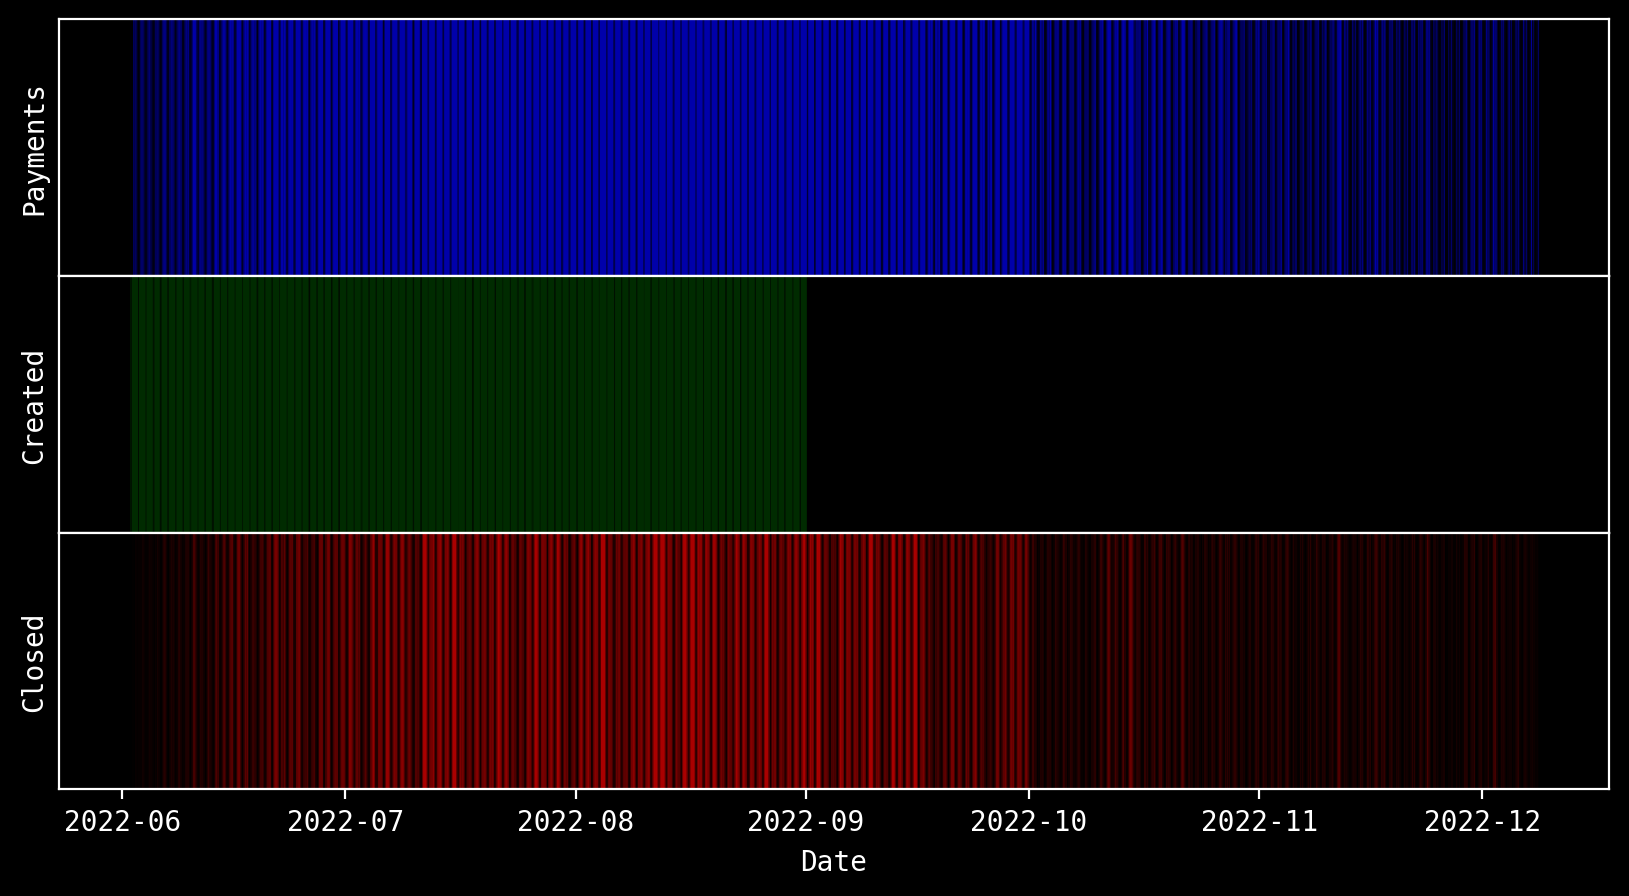

In [ ]:
fig, axes = plt.subplots(3, 1, sharex=True, dpi=200, figsize=(10, 5))


sns.rugplot([payments['paid_at'][i] for i in range(0, len(payments['paid_at']), 1)], color='blue', linewidth=.5, height=1, alpha=.01, ax=axes[0])
axes[0].set_ylabel('Payments')

sns.rugplot(orders['created_at'], color='green', linewidth=.5, height=1, alpha=.01, ax=axes[1])
axes[1].set_ylabel('Created')

sns.rugplot(orders['closed_at'], color='red', linewidth=.5, height=1, alpha=.01, ax=axes[2])
axes[2].set_ylabel('Closed')

axes[2].set_xlabel('Date')

for ax in axes:
  ax.set_yticks([])

plt.subplots_adjust(hspace=0)
plt.show()

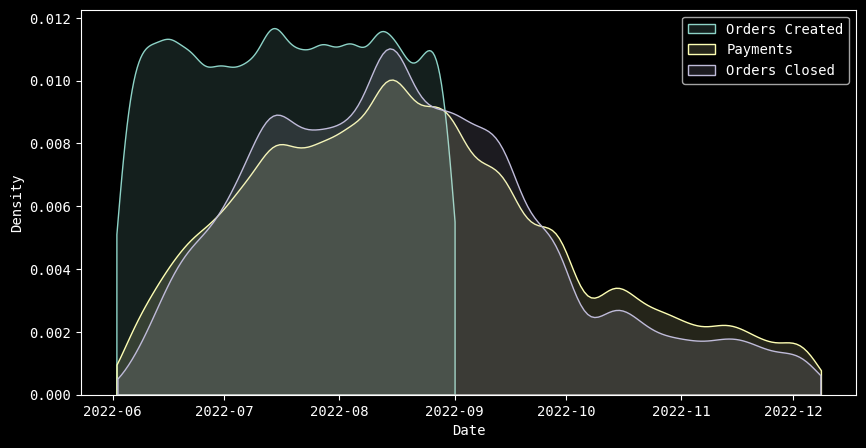

In [ ]:
fig = plt.figure(figsize=(10, 5))

sns.kdeplot(orders['created_at'], cut=0, fill=True, alpha=.15)
sns.kdeplot(payments['paid_at'], cut=0, fill=True, alpha=.15)
sns.kdeplot(orders['closed_at'], cut=0, fill=True, alpha=.15)

plt.legend(['Orders Created', 'Payments', 'Orders Closed'])
plt.xlabel('Date')
plt.show()

# Анализ плат

В данных наблюдается значительный спад плат: 2022-8-15, 2022-10 и 2022-10-15

Также кол-во план довольно переменчиво на протяжении месяца, самое большие и частые платы - 10-15 числа, также есть небольшой рост в начале и конце месяца, предположительно из-за получения зарплат

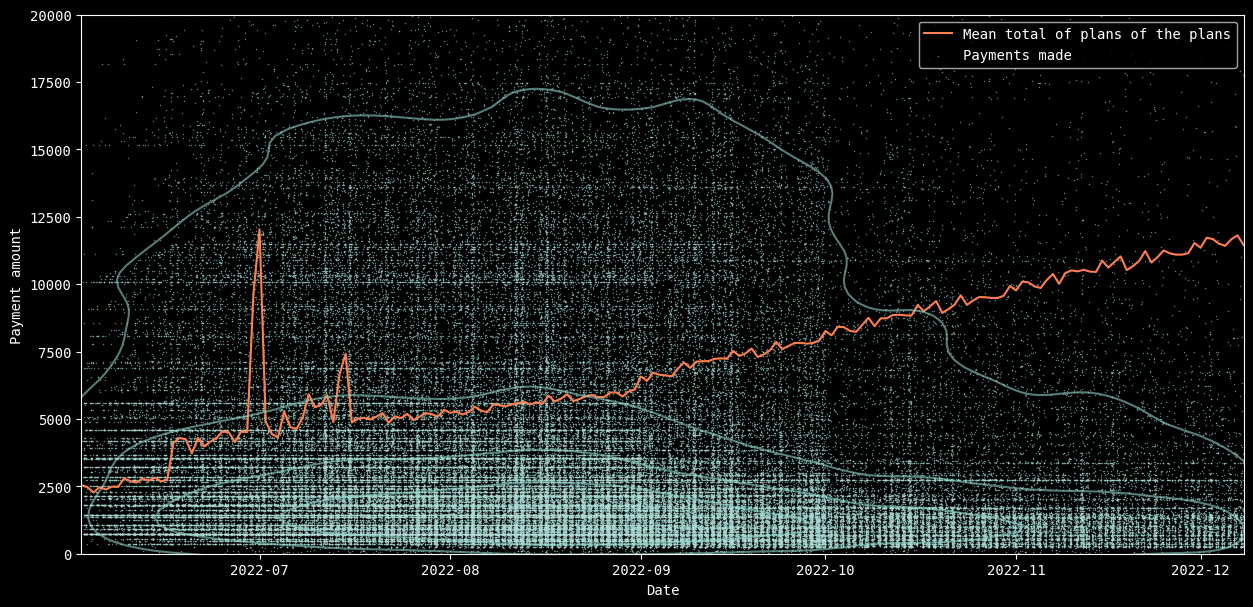

In [ ]:
gp_plan = plan.groupby('plan_at').mean()
gp_paym = payments.groupby('paid_at').mean()

plt.figure(dpi=100, figsize=(15, 7))

plt.plot(gp_plan.index, gp_plan['plan_sum_total'], '-', color='coral')
sns.scatterplot(x=gp_paym.index, y=gp_paym['paid_sum'], s=.8, alpha=.6)
sns.kdeplot(x=gp_paym.index, y=gp_paym['paid_sum'], levels=5, alpha=.6)

plt.legend(['Mean total of plans of the plans', 'Payments made'])
plt.ylabel('Payment amount')
plt.xlabel('Date')
plt.ylim(0, 20001)
plt.xlim(gp_plan.index.min(), gp_plan.index.max())
plt.show()

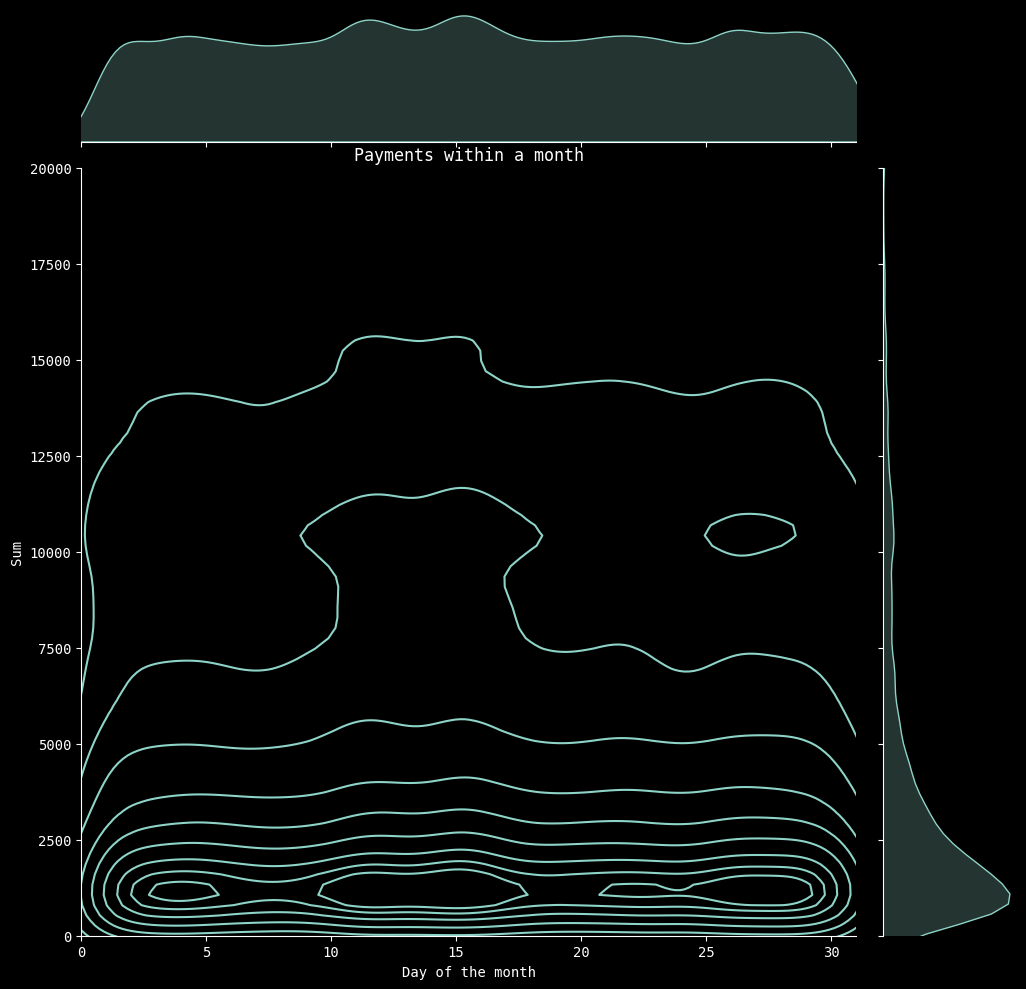

In [ ]:
sns.jointplot(x=pd.Series(gp_paym.index).dt.day, y=gp_paym['paid_sum'].to_numpy(), height=10, kind='kde', marginal_kws=dict(fill=True))

plt.xlim(0,31)
plt.ylim(0,20000)
plt.title('Payments within a month')
plt.ylabel('Sum')
plt.xlabel('Day of the month')
plt.show()

# Анализ просрочек

Основная и самая масштабная задача. После некоторых манипуляций и вычеслений можно построить графики, которые покажут динамику просрочек.

Даже несмотря на то, что данные не совсем правильны, можно увидеть, что статистически большинство просрочек было позже остальных планов примерно на полмесяца.

И даже не смотря на общее падение активности и отсутствие новых заказов, кол-во просрочек увиличивается, что показано мною в процентах.

In [ ]:
def get_total_payment(order_id, date, df=payments):
  df = df[(df['order_id'] == order_id) & (df['paid_at'] <= date)]
  return df['paid_sum'].sum()

def get_closest_payment(order_id, datetime):
  timedeltas = payments[payments['order_id']==order_id]['paid_at']-pd.to_datetime(datetime)
  timedeltas = timedeltas[timedeltas > pd.Timedelta(0)]
  #return timedeltas
  if not timedeltas.empty:
    closest = payments['paid_sum_total'][timedeltas.idxmin()]
    return closest
  else:
    return 0

payments['paid_sum_total'] = np.vectorize(get_total_payment)(payments['order_id'], payments['paid_at'])
plan['paid_sum_total_closest'] = np.vectorize(get_closest_payment)(plan['order_id'], plan['plan_at'])
plan['payment_late'] = plan['paid_sum_total_closest'].astype(int) < plan['plan_sum_total'].astype(int)
mask = plan['plan_at'] > plan['order_id'].map(sub_orders['closed_at'])
plan.loc[mask, 'payment_late'] = False

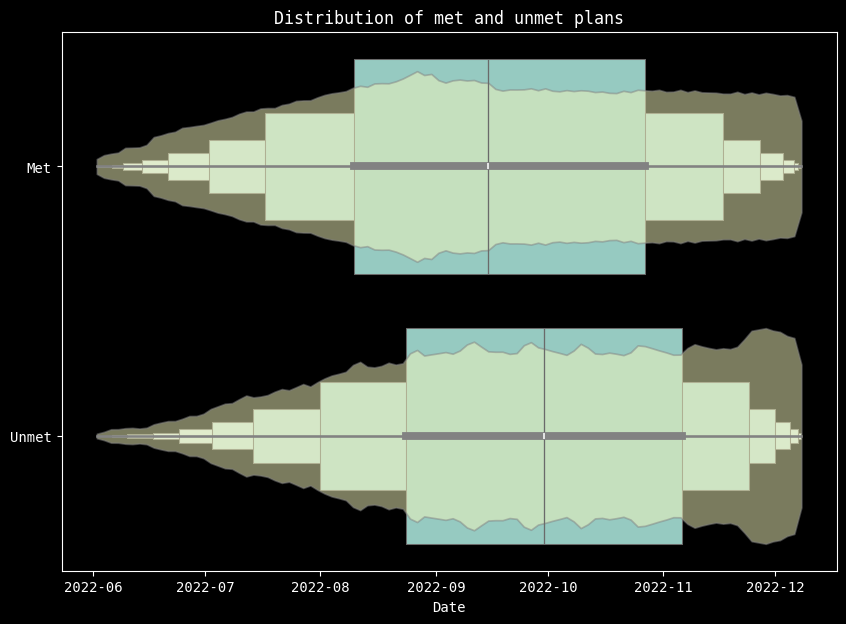

In [ ]:
plt.figure(figsize=(10, 7))

sns.boxenplot(x=plan['plan_at'], y=plan['payment_late'], orient='h')
sns.violinplot(x=plan['plan_at'], y=plan['payment_late'], orient='h', cut=0, alpha=0.5, bw_adjust=.25)

plt.yticks([0, 1], ['Met', 'Unmet'])

plt.title('Distribution of met and unmet plans')
plt.ylabel('')
plt.xlabel('Date')
plt.show()  # This graph is only partially correct, look "note on data" to see why

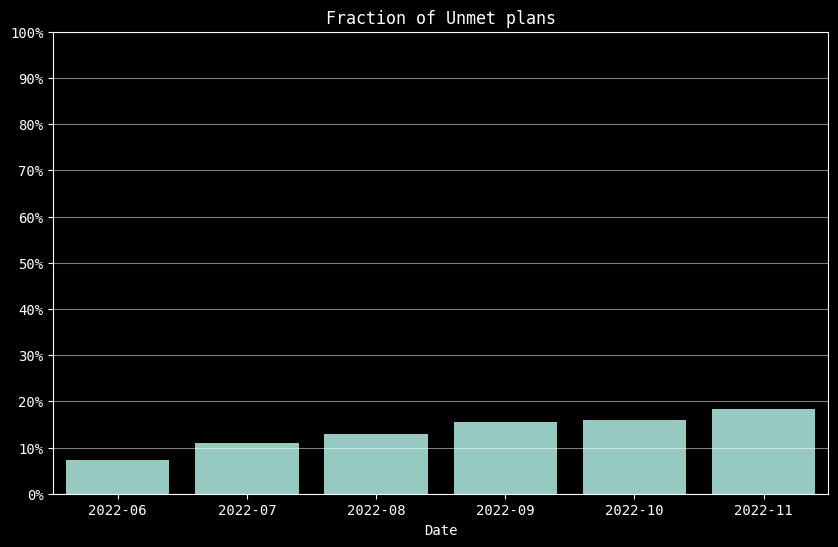

In [ ]:
timedelta = plan['plan_at'].max() - plan['plan_at'].min()
months = timedelta.days // 30
xticks = [(plan['plan_at'].min() + timedelta / months * i).strftime('%Y-%m') for i in range(months)]
yticks = np.arange(0, 1.1, .1)

cut_df = plan.copy()
cut_df['bin'] = pd.cut(cut_df['plan_at'].astype(int), bins=months)
cut_df_summary = cut_df.groupby('bin', observed=True)['payment_late'].mean().reset_index()

plt.figure(figsize=(10,6))

sns.barplot(x=cut_df_summary['bin'], y=cut_df_summary['payment_late'])

plt.xticks(range(months), xticks)
plt.yticks(yticks, [str(int(i*100)) + '%' for i in yticks])

plt.grid(True, alpha=.5, axis='y')
plt.title('Fraction of Unmet plans')
plt.xlabel('Date')
plt.ylabel('')
plt.show()

# Анализ по заказу

Чтобы решить проблему с дисбалансом в данных, я сгруппирую их под каждый заказ, это поможет оценить динамику вне зависимости от других клиентов и времени в целом.

В последующих таблицах (где 5 подтаблиц) я вычисляю "время заказа" как среднее арифметическое между созданием и последней платой. Также я предлагаю таблицу, где этот принцип был брошен в пользу оценки заказов по дате их создания.

С прошествием месяцев сдвигается распределение просрочек, в последние два месяца их большинство совершается раньше большинства остальных плановых плат.

В графике с процентами лучше всего видно число просрочек по времени, на графике с красной линией мой ответ на вопрос, увеличивается ли процент просрочек со временем или нет.

In [ ]:
def get_lates(dataframe, clip=True, time=True):  # Returns a dataframe of normalized(relative to the unique order) dates and either the plan was met
  def normalize_dates_in_df(dataframe):  # Sets normalized dates
    dataframe['plan_at'] = normalize_dates(dataframe['plan_at'])
    if clip:
      dataframe['plan_at'] = dataframe['plan_at'].clip(0, 1)
    return dataframe

  def normalize_dates(series):
    max_date = series.max().value
    min_date = sub_orders.loc[dataframe['order_id'].iloc[0]]['created_at'].value
    series = series.astype('int64')
    series = (series - min_date) / (max_date - min_date)
    return series

  orders_gp = pd.Series(dict(tuple(dataframe.groupby('order_id'))))  # Get series out of a groupby

  if time:
   orders_gp.apply(normalize_dates_in_df)

  lates = []
  for i in orders_gp:  # [[.5, True], ...]
    for j in range(len(i)):
      row = i.iloc[j]
      if time:
        lates.append([row['plan_at'], row['payment_late']])
      else:
        lates.append([row['payment_late']])

  return pd.DataFrame(lates)

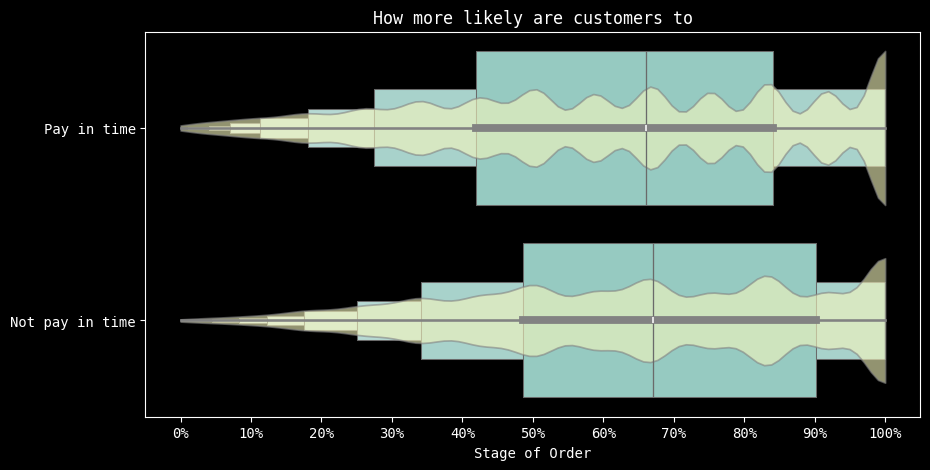

In [ ]:
lates = get_lates(plan)
xticks = np.arange(0, 1.1, .1)

plt.figure(figsize=(10, 5))

sns.boxenplot(x=lates[0], y=lates[1], orient='h')
sns.violinplot(x=lates[0], y=lates[1], orient='h', alpha=.6, cut=0)

plt.yticks([0, 1], ['Pay in time', 'Not pay in time'])
plt.xticks(xticks, [str(int(i*100)) + '%' for i in xticks])

plt.title('How more likely are customers to')
plt.ylabel('')
plt.xlabel('Stage of Order')
plt.show()

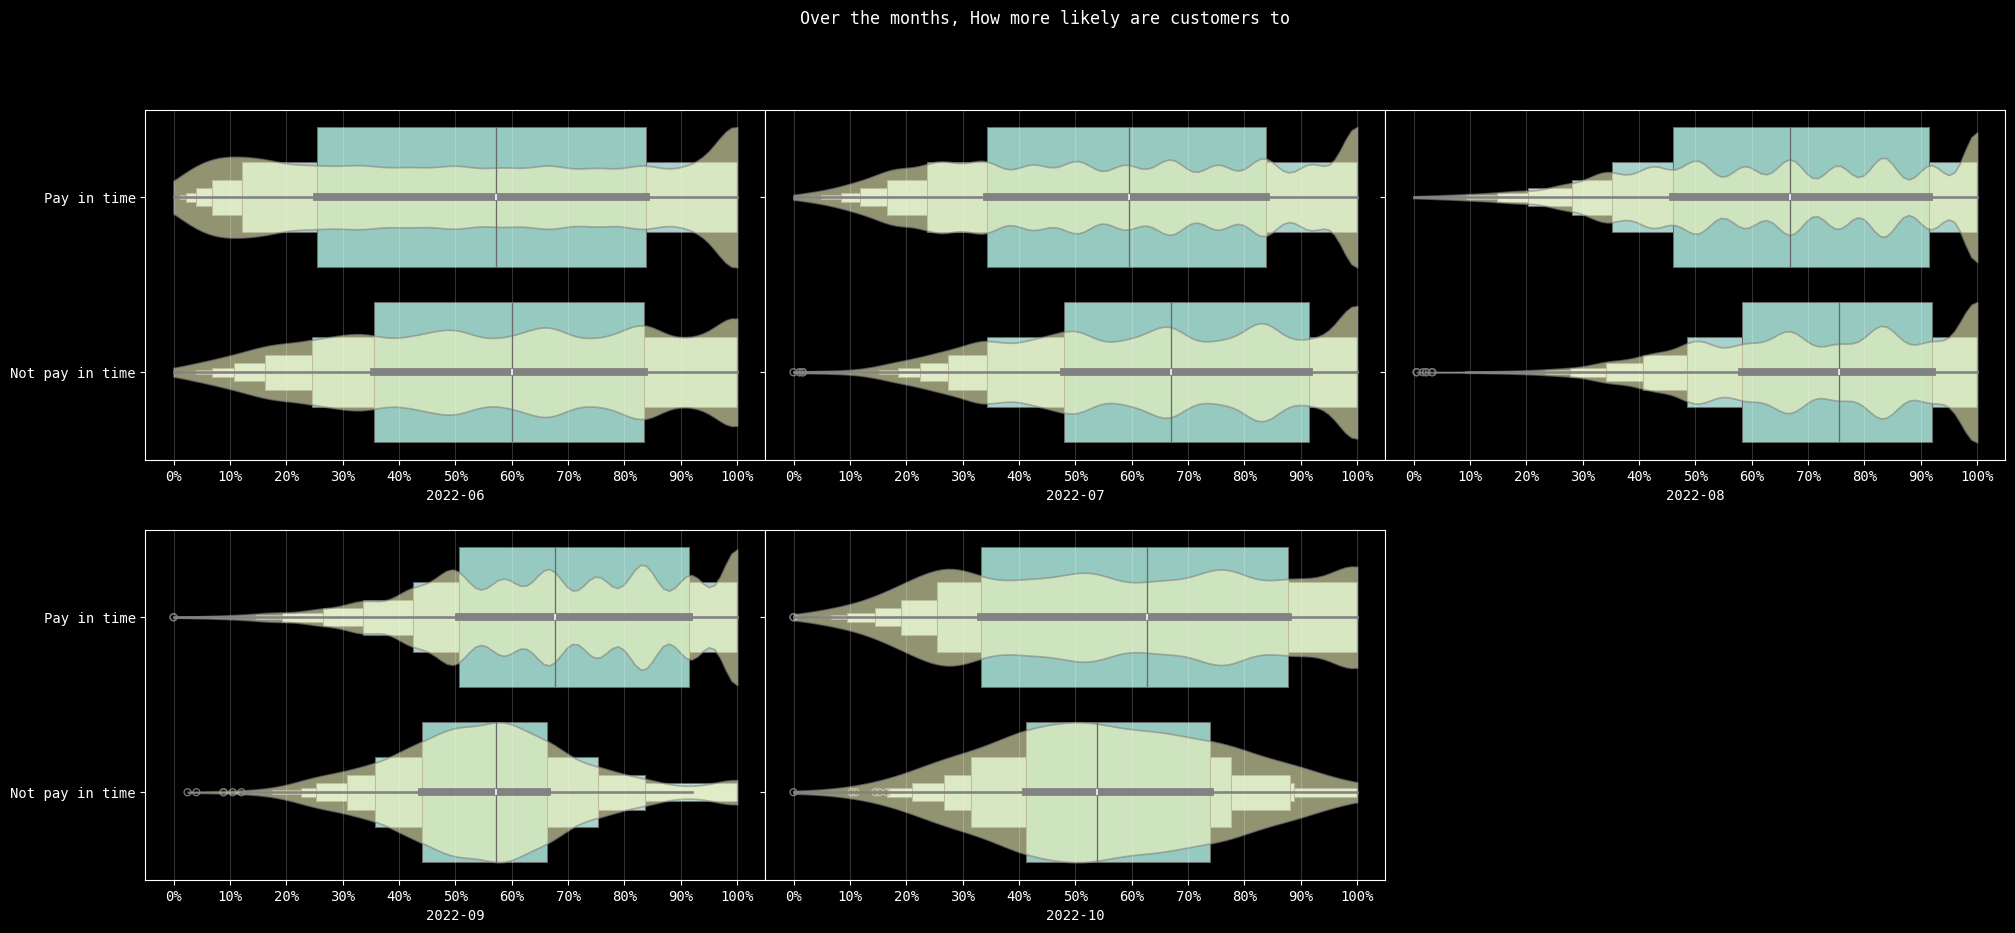

In [ ]:
cut_df = plan.copy()
cut_df.loc[:, 'mean_time_order'] = cut_df['order_id'].map(sub_orders_dict)
cut_df['bin'] = cut_df.loc[:, 'mean_time_order'].dt.month - cut_df.loc[:, 'mean_time_order'].min().month
months = cut_df['bin'].nunique()

timedelta = plan['plan_at'].max() - plan['plan_at'].min()
months = timedelta.days // 30
xlabels = [(plan['plan_at'].min() + timedelta / months * i).strftime('%Y-%m') for i in range(months)]
xticks = np.arange(0, 1.1, .1)

ncols = int(np.ceil(np.sqrt(months)))
nrows = int(np.ceil(months / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(8*ncols, 5*nrows), sharey=True)
axes = axes.flatten()

for i in range(months):
  ax = axes[i]
  lates = get_lates(cut_df[cut_df['bin'] == i])
  if lates.empty:
    ax.set_visible(False)
    continue

  sns.boxenplot(x=lates[0], y=lates[1], orient='h', ax=ax)
  sns.violinplot(x=lates[0], y=lates[1], orient='h', alpha=.6, cut=0, ax=ax)

  ax.set_yticks([0, 1], ['Pay in time', 'Not pay in time'])
  ax.set_xticks(xticks, [str(int(i*100)) + '%' for i in xticks])

  ax.grid(True, alpha=.2, axis='x')
  ax.set_xlabel(xlabels[i])
  ax.set_ylabel('')

for i in range(months, len(axes)):
    axes[i].set_visible(False)

plt.subplots_adjust(wspace=0, hspace=.2)
plt.suptitle('Over the months, How more likely are customers to')
plt.show()

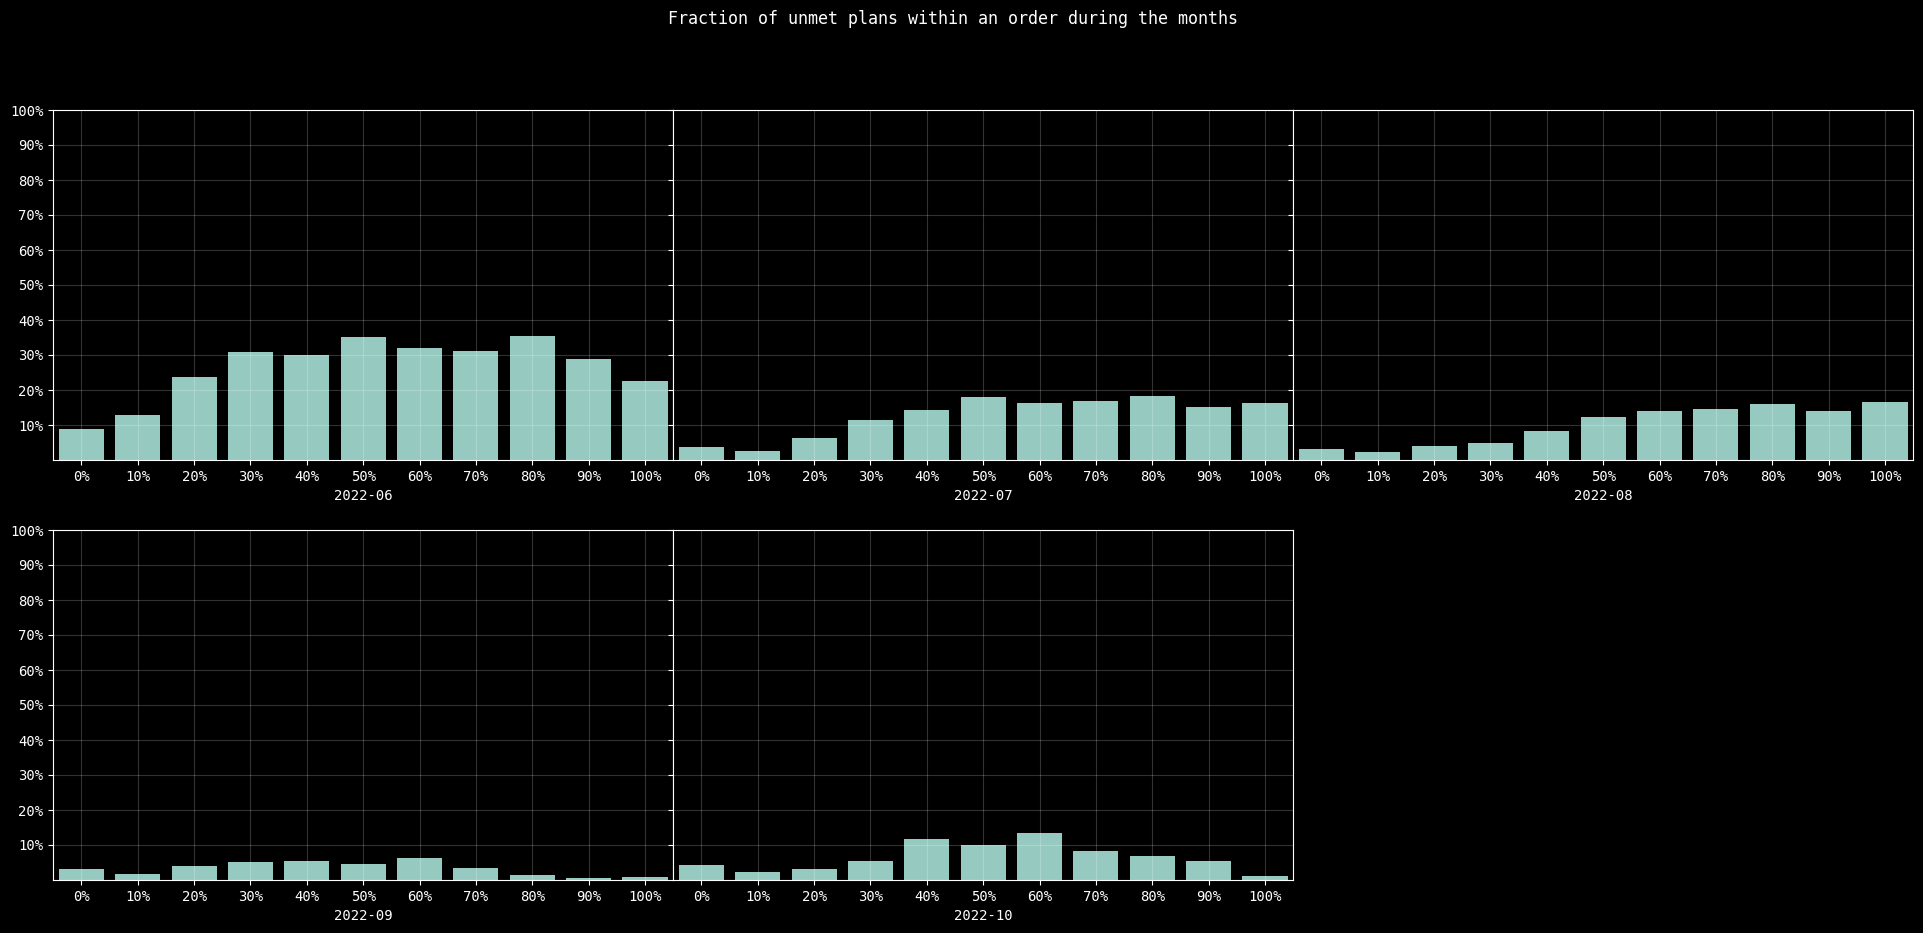

In [ ]:
cut_df = plan.copy()
cut_df.loc[:, 'mean_time_order'] = cut_df['order_id'].map(sub_orders_dict)
cut_df['bin'] = cut_df.loc[:, 'mean_time_order'].dt.month - cut_df.loc[:, 'mean_time_order'].min().month
months = cut_df['bin'].nunique()

timedelta = plan['plan_at'].max() - plan['plan_at'].min()
xlabels = [(plan['plan_at'].min() + timedelta / months * i).strftime('%Y-%m') for i in range(months)]
xticks = np.arange(11)
yticks = np.arange(.1, 1.1, .1)

ncols = int(np.ceil(np.sqrt(months)))
nrows = int(np.ceil(months / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(8*ncols, 5*nrows), sharey=True)
axes = axes.flatten()

for i in range(months):
  ax = axes[i]
  lates = pd.DataFrame(get_lates(cut_df[cut_df['bin'] == i]))

  cut_lates = lates.copy()
  cut_lates.loc[:, 'bin'] = (cut_lates[0]*10).round() / 10
  cut_lates_summary = cut_lates.groupby('bin', observed=True)[1].mean().reset_index()

  sns.barplot(x=cut_lates_summary['bin'], y=cut_lates_summary[1], ax=ax)

  ax.set_yticks(yticks, [str(int(i*100)) + '%' for i in yticks])
  ax.set_xticks(xticks, [str(int(i*10)) + '%' for i in xticks])

  ax.grid(True, alpha=.2)
  ax.set_xlabel(xlabels[i])
  ax.set_ylabel('')

for i in range(months, len(axes)):
    axes[i].set_visible(False)

plt.subplots_adjust(wspace=0, hspace=.2)
plt.suptitle('Fraction of unmet plans within an order during the months')
plt.show()

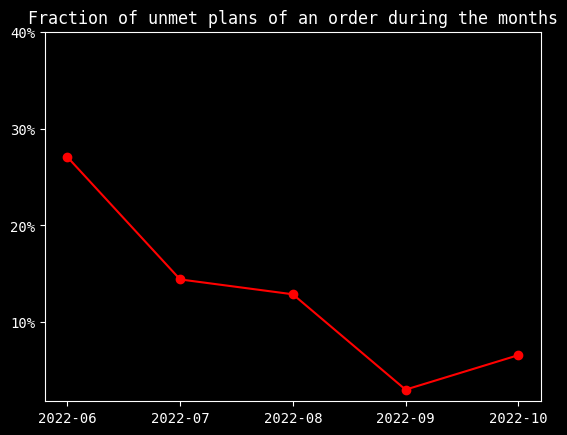

In [ ]:
cut_df = plan.copy()
cut_df.loc[:, 'mean_time_order'] = cut_df['order_id'].map(sub_orders_dict)
cut_df['bin'] = cut_df.loc[:, 'mean_time_order'].dt.month - cut_df.loc[:, 'mean_time_order'].min().month
months = cut_df['bin'].nunique()

timedelta = plan['plan_at'].max() - plan['plan_at'].min()
xlabels = [(plan['plan_at'].min() + timedelta / months * i).strftime('%Y-%m') for i in range(months)]
xticks = np.arange(11)
yticks = np.arange(.1, .4, .1)

lates = []

for i in range(months):
    axes[i].set_visible(False)
    lates.append(pd.DataFrame(get_lates(cut_df[cut_df['bin'] == i], time=False)).mean())


plt.plot(range(months), lates, color='red', marker='o')

plt.xticks(range(months), xlabels)
plt.yticks(yticks, [str(int(i*100)) + '%' for i in yticks])
plt.title('Fraction of unmet plans of an order during the months')
plt.show()   # Self-explaining graph, the path to it needs explanation though

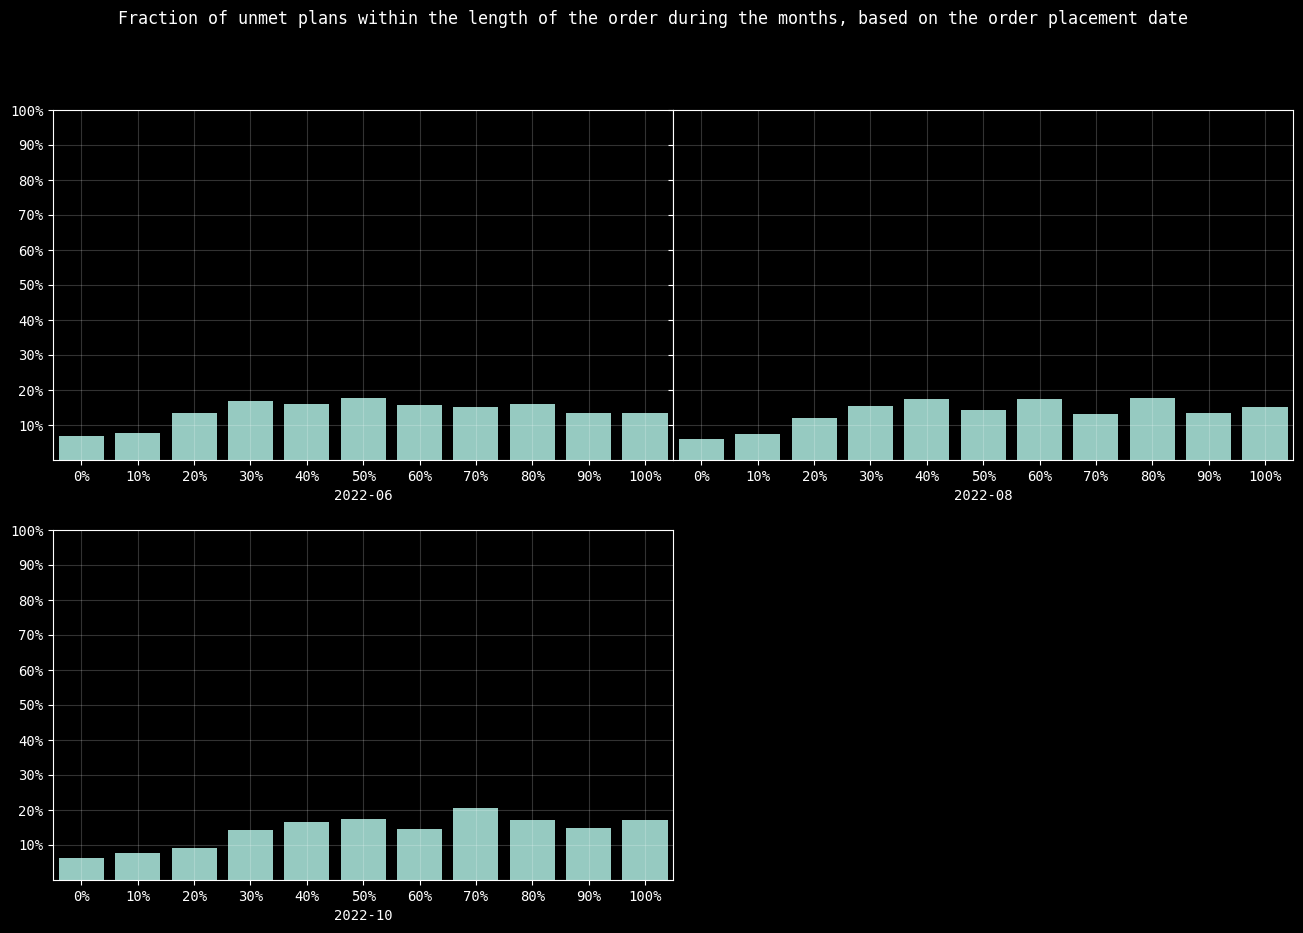

In [ ]:
cut_df = plan.copy()
cut_df.loc[:, 'created_at'] = cut_df['order_id'].map(sub_orders['created_at'])
cut_df['bin'] = cut_df.loc[:, 'created_at'].dt.month - cut_df.loc[:, 'created_at'].min().month
months = cut_df['bin'].nunique()

xlabels = [(plan['plan_at'].min() + timedelta / months * i).strftime('%Y-%m') for i in range(months)]
xticks = np.arange(11)
yticks = np.arange(.1, 1.1, .1)

ncols = int(np.ceil(np.sqrt(months)))
nrows = int(np.ceil(months / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(8*ncols, 5*nrows), sharey=True)
axes = axes.flatten()

for i in range(months):
  ax = axes[i]
  lates = pd.DataFrame(get_lates(cut_df[cut_df['bin'] == i]))

  cut_lates = lates.copy()
  cut_lates.loc[:, 'bin'] = (cut_lates[0]*10).round() / 10
  cut_lates_summary = cut_lates.groupby('bin', observed=True)[1].mean().reset_index()

  sns.barplot(x=cut_lates_summary['bin'], y=cut_lates_summary[1], ax=ax)

  ax.set_yticks(yticks, [str(int(i*100)) + '%' for i in yticks])
  ax.set_xticks(xticks, [str(int(i*10)) + '%' for i in xticks])

  ax.grid(True, alpha=.2)
  ax.set_xlabel(xlabels[i])
  ax.set_ylabel('')

for i in range(months, len(axes)):
    axes[i].set_visible(False)

plt.subplots_adjust(wspace=0, hspace=.2)
plt.suptitle('Fraction of unmet plans within the length of the order during the months, based on the order placement date')
plt.show()  # This would be important if the agreement changed, this graph shows data irregadless of the order length, so I wouldn't trust it

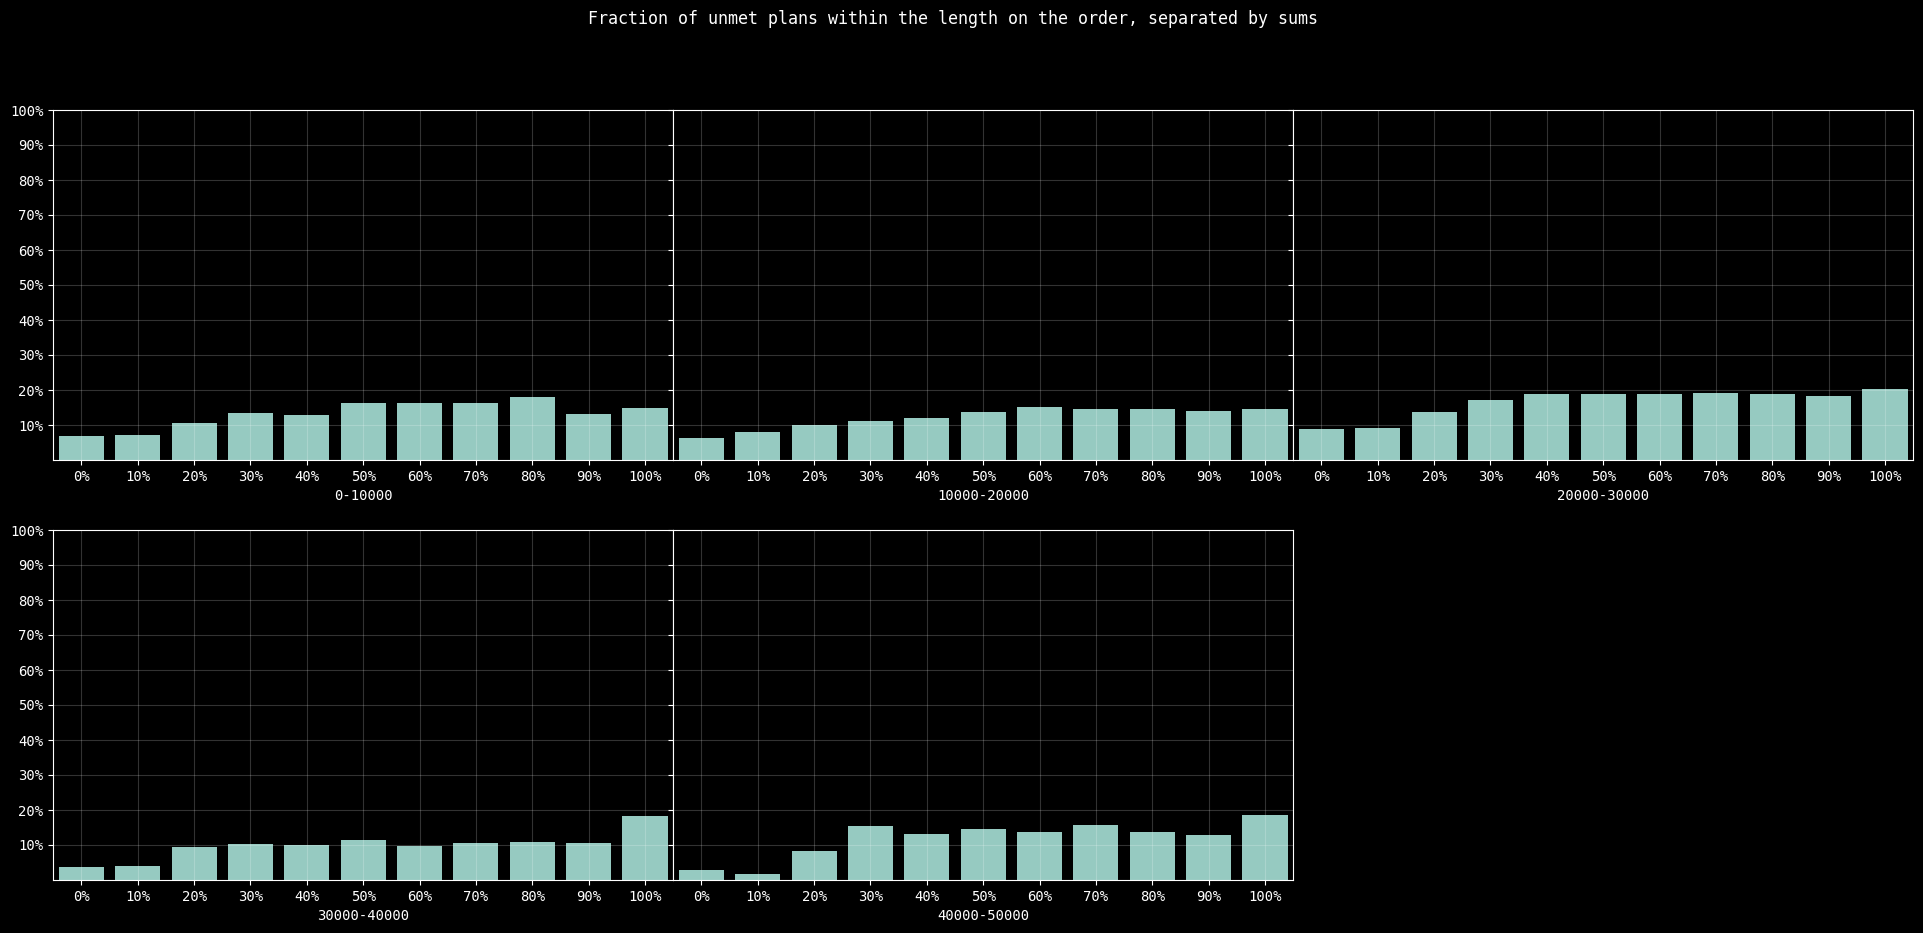

In [ ]:
final_sums = plan[['order_id', 'plan_sum_total']]
final_sums = final_sums.groupby('order_id').max().to_dict()['plan_sum_total']

categories = 5
sum_per_category = 10000

cut_df = plan.copy()
cut_df['final_sum'] = cut_df['order_id'].map(final_sums)
cut_df = cut_df[cut_df['final_sum'] <= categories * sum_per_category]
cut_df['bin'] = pd.cut(cut_df['final_sum'], categories, labels=range(categories))

xticks = np.arange(11)
yticks = np.arange(.1, 1.1, .1)

ncols = int(np.ceil(np.sqrt(categories)))
nrows = int(np.ceil(categories / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(8*ncols, 5*nrows), sharey=True)
axes = axes.flatten()

for i in range(categories):
  ax = axes[i]
  lates = pd.DataFrame(get_lates(cut_df[cut_df['bin'] == i]))

  cut_lates = lates.copy()
  cut_lates.loc[:, 'bin'] = (cut_lates[0]*10).round() / 10
  cut_lates_summary = cut_lates.groupby('bin', observed=True)[1].mean().reset_index()

  sns.barplot(x=cut_lates_summary['bin'], y=cut_lates_summary[1], ax=ax)

  ax.set_yticks(yticks, [str(int(i*100)) + '%' for i in yticks])
  ax.set_xticks(xticks, [str(int(i*10)) + '%' for i in xticks])

  ax.grid(True, alpha=.2)
  ax.set_xlabel(f"{i * sum_per_category}-{(i+1) * sum_per_category}")
  ax.set_ylabel('')

for i in range(categories, len(axes)):
    axes[i].set_visible(False)

plt.subplots_adjust(wspace=0, hspace=.2)
plt.suptitle('Fraction of unmet plans within the length on the order, separated by sums')
plt.show()  # A difference within a margin of error, but it needed to be looked into

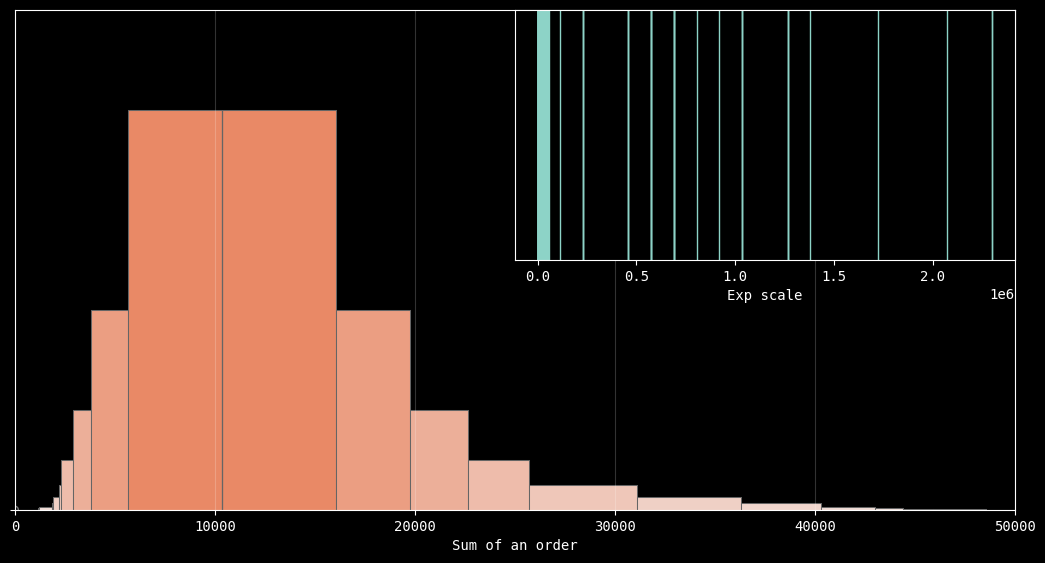

In [ ]:
cut_df = plan.copy()
cut_df['final_sum'] = cut_df['order_id'].map(final_sums)

fig = plt.figure(figsize=(10, 5))
axes = [0]*2

axes[0] = fig.add_axes([0, 0, 1, 1])
axes[1] = fig.add_axes([.5, .5, .5, .5])

sns.boxenplot(cut_df['final_sum'], orient='h', color='coral', ax=axes[0])
sns.rugplot(cut_df['final_sum'], height=1, ax=axes[1])

ymin, ymax = axes[0].get_ylim()
axes[0].set_ylim(ymin - .5, ymax)
axes[0].set_xlim(0, 50000)
axes[0].grid(True, alpha=.2)
axes[0].set_xlabel('Sum of an order')

axes[1].set_yticks([])
axes[1].set_xlabel('Exp scale')

plt.show()  # Basic stats, moved here because of data-engineering needed

# Анализ общего долга

Из-за вышеописанных проблем в данных размер долга возвращается на нулевое значение, так как большинство заказов завершается, даже если и не по времени.

Также видны четыре выбивающихся долга.

In [ ]:
sub_plan = plan[plan['plan_at'] < plan['order_id'].map(sub_orders['closed_at'])].copy()
sub_plan['plan_sum_diff'] = (sub_plan['paid_sum_total_closest'] - sub_plan['plan_sum_total'])
sub_plan = sub_plan[sub_plan['payment_late']]
sub_plan_gp = sub_plan.groupby('plan_at').mean()

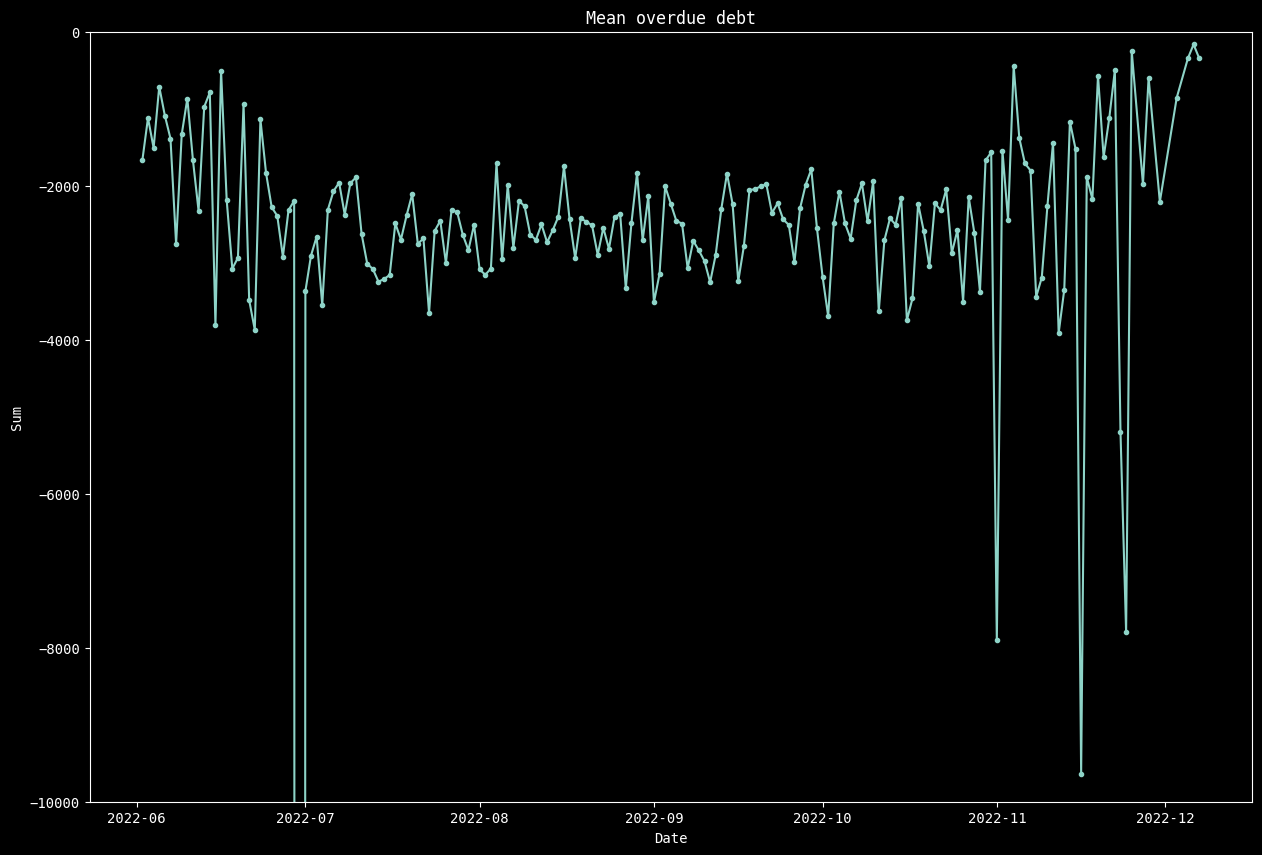

In [ ]:
sub_plan_gp = sub_plan.groupby('plan_at').mean()

plt.figure(figsize=(15, 10))

plt.plot(sub_plan_gp.index, sub_plan_gp['plan_sum_diff'], marker='.')

plt.ylim(-10000, 0)
plt.title('Mean overdue debt')
plt.xlabel('Date')
plt.ylabel('Sum')
plt.show()  # A few outliers here, could be looked into, also dept doesn't seem to be increasing

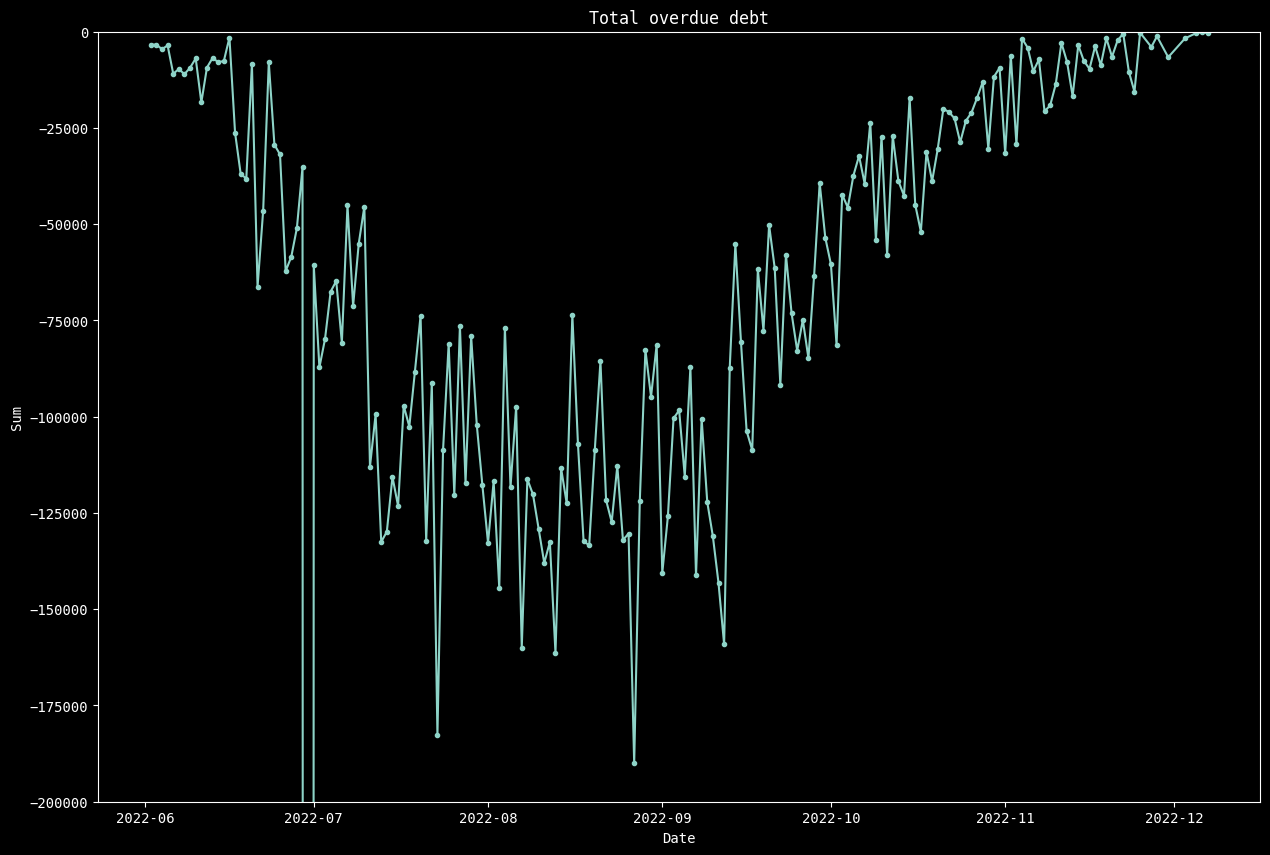

In [ ]:
sub_plan_gp = sub_plan.groupby('plan_at').sum()

plt.figure(figsize=(15, 10))

plt.plot(sub_plan_gp.index, sub_plan_gp['plan_sum_diff'], marker='.')

plt.ylim(-200000, 0)
plt.title('Total overdue debt')
plt.xlabel('Date')
plt.ylabel('Sum')
plt.show()  # The debt is decreasing only because of no orders taken after 2022-09, the sum between 2022-8 and 2022-09 would be normal if the intake was constant